# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 9)


,year,id_,age,gunlaw,owngun,rowngun,cohort,ballot,wtssall
0,1972,1,23,1,0,0,1949,0,0.4446
1,1972,2,70,1,0,0,1902,0,0.8893
2,1972,3,48,1,0,0,1924,0,0.8893
3,1972,4,27,1,0,0,1945,0,0.8893
4,1972,5,61,1,0,0,1911,0,0.8893


Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [3]:
gss.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
sum(~gss.gunlaw.isnull())

40472

In [4]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [5]:
gss.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
sum(~gss.owngun.isnull())

37640

In [6]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [7]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [8]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

Drop records if age or cohort is missing.

In [9]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(62244, 9)

We drop 222 records due to missing data.

In [10]:
62466 - 62244

222

Here's the distribution of ages.

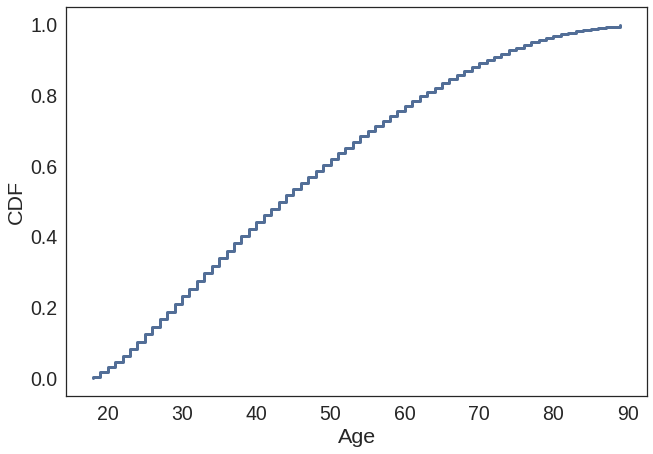

In [11]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [12]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

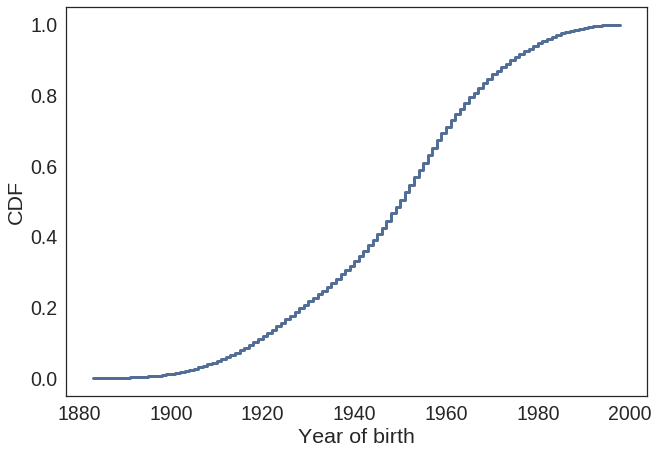

In [13]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [14]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [15]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1881.5       2
1886.5      36
1891.5     118
1896.5     306
1901.5     566
1906.5     833
1911.5    1239
1916.5    1666
1921.5    2001
1926.5    2161
1931.5    2110
1936.5    2488
1941.5    2947
1946.5    3749
1951.5    4257
1956.5    3999
1961.5    3365
1966.5    2634
1971.5    1981
1976.5    1488
1981.5    1108
1986.5     760
1991.5     410
1996.5     115
Name: gunlaw, dtype: int64

In [16]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [17]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     392
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [18]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
Name: year, dtype: int64

In [19]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [20]:
center_factors(gss)

Create the dependent variables

In [21]:
gss['favor'] = (gss.gunlaw == 1.0).astype(int)
gss.loc[gss.gunlaw.isnull(), 'favor'] = np.nan

gss['gunhome'] = (gss.owngun == 1.0).astype(int)
gss.loc[gss.owngun.isnull(), 'gunhome'] = np.nan


## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [22]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,id_,age,gunlaw,owngun,rowngun,cohort,ballot,wtssall,age_group,cohort5,cohort10,ones,c,a,c2,a2,ac,favor,gunhome
0,1972,90,20.0,1.0,NaN,0,1952.0,0,0.8893,22.5,1951.5,1950.0,1.0,-14.0,-27.0,196.0,729.0,378.0,1.0,NaN
1,1972,1454,63.0,1.0,NaN,0,1909.0,0,2.6679,62.5,1911.5,1900.0,1.0,-57.0,16.0,3249.0,256.0,-912.0,1.0,NaN
2,1972,740,21.0,1.0,NaN,0,1951.0,0,1.3339,22.5,1951.5,1950.0,1.0,-15.0,-26.0,225.0,676.0,390.0,1.0,NaN
3,1972,607,50.0,1.0,NaN,0,1922.0,0,1.7786,52.5,1921.5,1920.0,1.0,-44.0,3.0,1936.0,9.0,-132.0,1.0,NaN
4,1972,891,52.0,NaN,NaN,0,1920.0,0,1.7786,52.5,1921.5,1920.0,1.0,-46.0,5.0,2116.0,25.0,-230.0,NaN,NaN


### Run logistic models



In [23]:
formula = 'favor ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.548935
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40289
Model:                          Logit   Df Residuals:                    40286
Method:                           MLE   Df Model:                            2
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:               0.0006981
Time:                        11:50:30   Log-Likelihood:                -22116.
converged:                       True   LL-Null:                       -22131.
                                        LLR p-value:                 1.951e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2569      0.022     57.470      0.000       1.214       1.300
c              0.0047      0.001      5.391      0.000       0.003       0.006
a              0.0035      0.001      3.301      0.001       0.001       0.006
==============================================================================
"""

In [24]:
def model_predict(model, new):
    res = new.copy()
    res['pred'] = model.predict(new) * 100
    res['diff'] = res.pred - res.pred[0]
    return res[['cohort', 'age',  'pred', 'diff']]

In [25]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [26]:
model_predict(model, new)

,cohort,age,pred,diff
0,1971,46,78.191633,0.000000
1,2000,18,78.818591,0.626958
2,2000,46,80.422042,2.230409


In [27]:
formula = 'favor ~ c + a + c2 + a2 + ac'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.546536
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40289
Model:                          Logit   Df Residuals:                    40283
Method:                           MLE   Df Model:                            5
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:                0.005065
Time:                        11:50:31   Log-Likelihood:                -22019.
converged:                       True   LL-Null:                       -22131.
                                        LLR p-value:                 1.893e-46
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0348      0.028     37.549      0.000       0.981       1.089
c             -0.0291      0.003    -10.084      0.000      -0.035      -0.023
a             -0.0257      0.003     -8.259      0.000      -0.032      -0.020
c2            -0.0009   7.01e-05    -12.364      0.000      -0.001      -0.001
a2            -0.0005   9.14e-05     -5.053      0.000      -0.001      -0.000
ac            -0.0015      0.000    -10.354      0.000      -0.002      -0.001
==============================================================================
"""

In [28]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [29]:
model_predict(model, new)

,cohort,age,pred,diff
0,1971,46,71.102668,0.000000
1,2000,18,70.990600,-0.112068
2,2000,46,29.305963,-41.796706


In [30]:
formula = 'gunhome ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.672538
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                gunhome   No. Observations:                37387
Model:                          Logit   Df Residuals:                    37384
Method:                           MLE   Df Model:                            2
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:                 0.01465
Time:                        11:50:31   Log-Likelihood:                -25144.
converged:                       True   LL-Null:                       -25518.
                                        LLR p-value:                4.753e-163
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6740      0.020    -34.437      0.000      -0.712      -0.636
c             -0.0203      0.001    -24.500      0.000      -0.022      -0.019
a             -0.0122      0.001    -12.235      0.000      -0.014      -0.010
==============================================================================
"""

In [31]:
formula = 'gunhome ~ c + a + a2 + c2'
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.666538
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                gunhome   No. Observations:                37387
Model:                          Logit   Df Residuals:                    37382
Method:                           MLE   Df Model:                            4
Date:                Mon, 26 Feb 2018   Pseudo R-squ.:                 0.02344
Time:                        11:50:31   Log-Likelihood:                -24920.
converged:                       True   LL-Null:                       -25518.
                                        LLR p-value:                1.079e-257
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5661      0.022    -25.307      0.000      -0.610      -0.522
c             -0.0330      0.001    -26.756      0.000      -0.035      -0.031
a             -0.0093      0.001     -9.317      0.000      -0.011      -0.007
a2            -0.0003   3.97e-05     -6.821      0.000      -0.000      -0.000
c2            -0.0003   2.44e-05    -13.818      0.000      -0.000      -0.000
==============================================================================
"""

## Favor gunlaw

In [32]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

In [33]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        series.replace([0.0], np.nan, inplace=True)
        thinkplot.plot(series.dropna(), color=color, label=label)

In [34]:
def plot_gunlaw(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [35]:
grouped_year = sample.groupby(['year'])
make_series_seq(grouped_year, ['favor'])

[year
 1972    71.953578
 1973    72.609290
 1974    76.965517
 1975    75.172414
 1976    71.759891
 1977    72.018654
 1978          NaN
 1980    71.866295
 1982    72.556599
 1983          NaN
 1984    71.388302
 1985    73.133333
 1986          NaN
 1987    74.122310
 1988    76.433121
 1989    82.038345
 1990    78.876404
 1991    81.750267
 1993    82.053743
 1994    79.624937
 1996    80.280929
 1998    82.000000
 2000    80.298013
 2002    84.703434
 2004    78.087167
 2006    79.532468
 2008    79.607251
 2010    73.527101
 2012    73.348873
 2014    73.056692
 2016    71.223404
 Name: favor, dtype: float64]

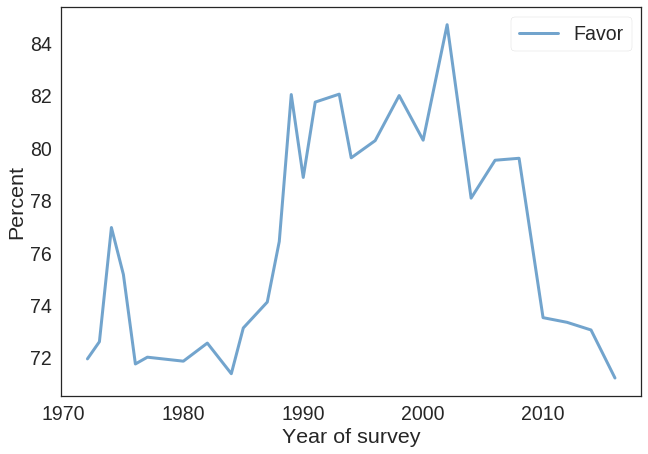

In [36]:
plot_gunlaw(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [37]:
grouped_age = sample.groupby(['age_group'])

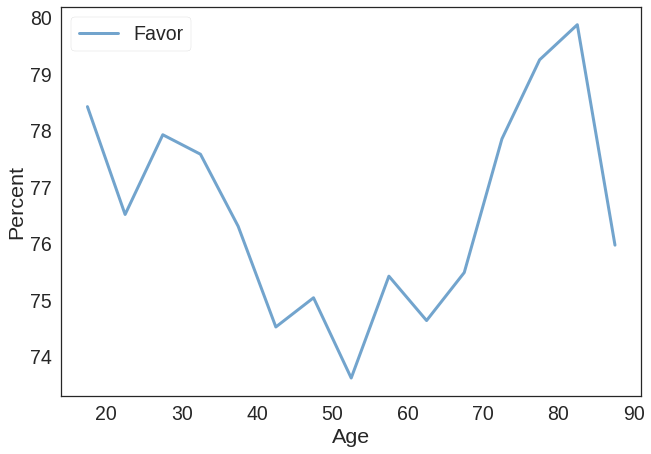

In [38]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [39]:
grouped_cohort = sample.groupby(['cohort5'])

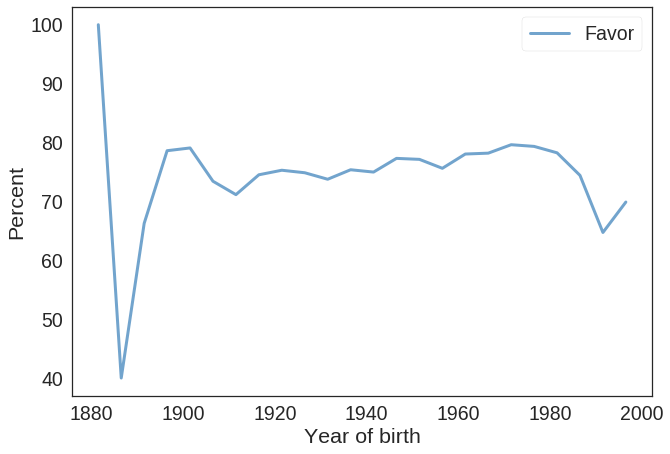

In [40]:
plot_gunlaw(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [41]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [42]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
model = make_logit_model(sample, 'favor', factors)

In [43]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [44]:
age = sample.loc[sample.year==2016, 'age']

In [45]:
predict_logit_model(age, model, 1976, factors)

71.543577178858939

In [46]:
predict_logit_model(age, model, 2016, factors)

73.048652432621637

In [47]:
predict_logit_model(age, model, 2026, factors)

64.613230661533066

In [48]:
predict_logit_model(age, model, 2036, factors)

50.437521876093804

In [49]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [50]:
def plot_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

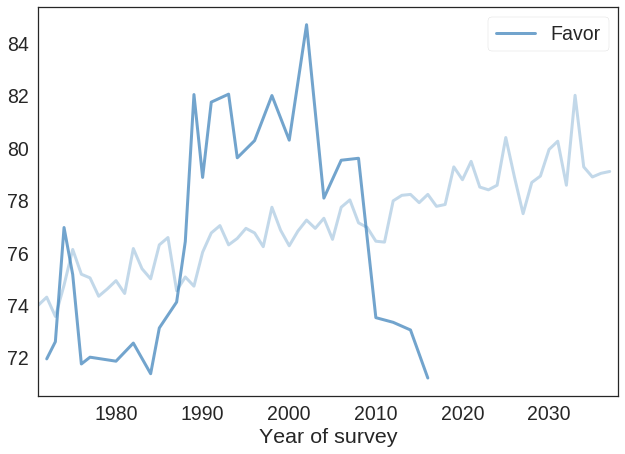

In [51]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

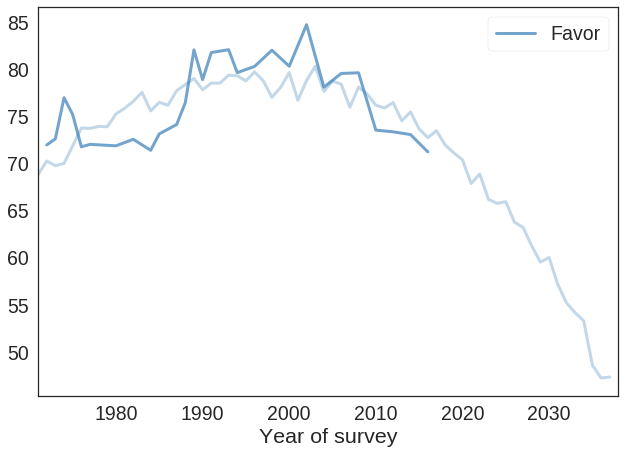

In [52]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [53]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [54]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [55]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [56]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [57]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Gun permits

In [58]:
iters = 101

In [59]:
groupvar = 'year'
varnames = ['favor']

In [60]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

Writing permit_year.png


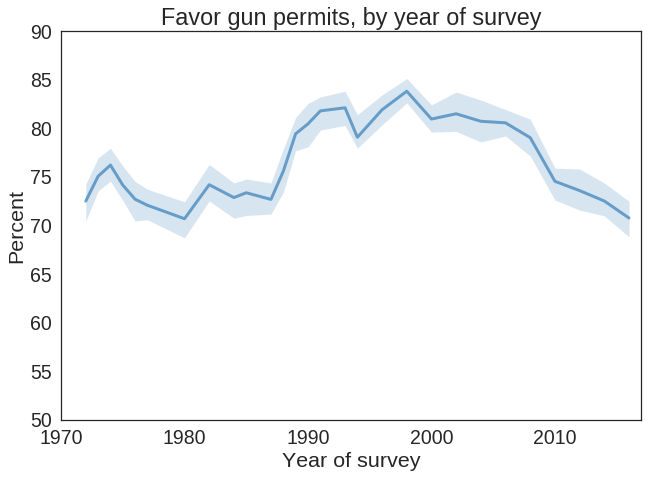

In [61]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun permits, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[50, 90])

thinkplot.SaveFormat('permit_year', 'png')

In [62]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

Writing permit_cohort.png


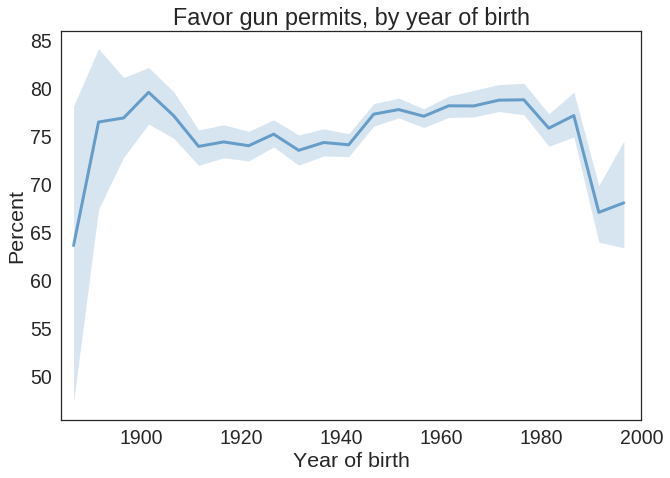

In [63]:
plot_percentiles(dfs2, varnames, colors, labels)
thinkplot.config(title='Favor gun permits, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], yim=[50, 90])

thinkplot.SaveFormat('permit_cohort', 'png')

In [64]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

Writing permit_pred.png


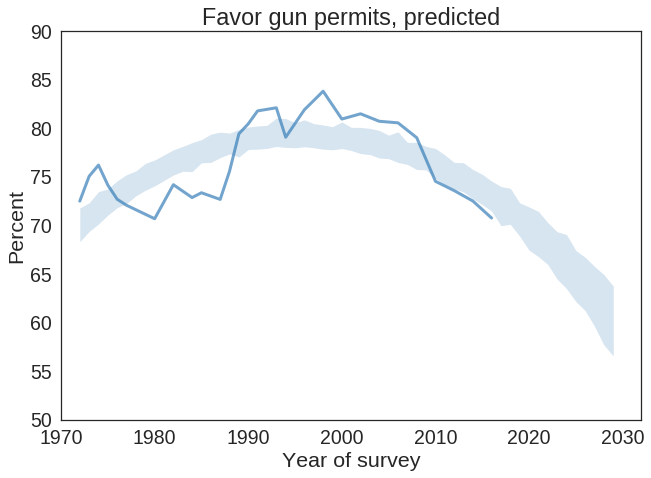

In [65]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun permits, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', 'png')

## Gun in home

In [66]:
groupvar = 'year'
varnames = ['gunhome']

In [67]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

Writing gunhome_year.png


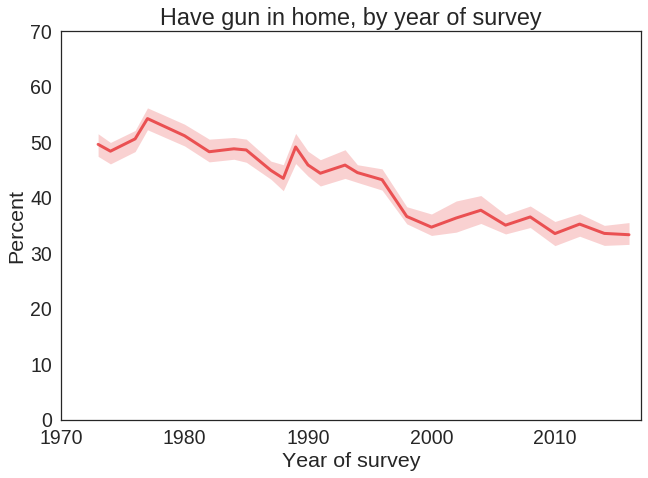

In [68]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', 'png')

In [69]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

Writing gunhome_cohort.png


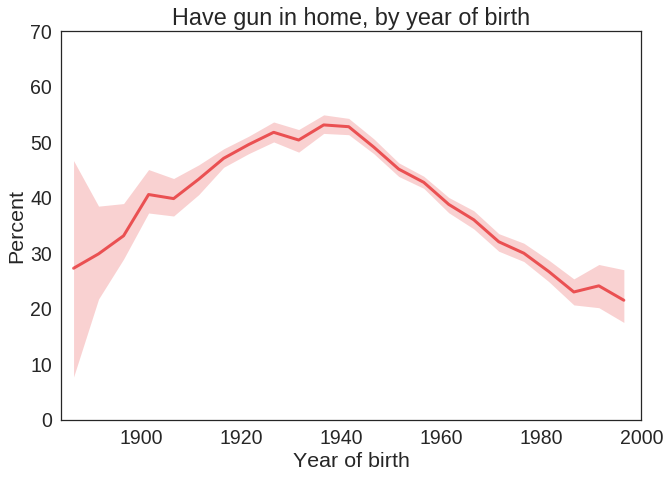

In [70]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', 'png')

In [71]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

Writing gunhome_pred.png


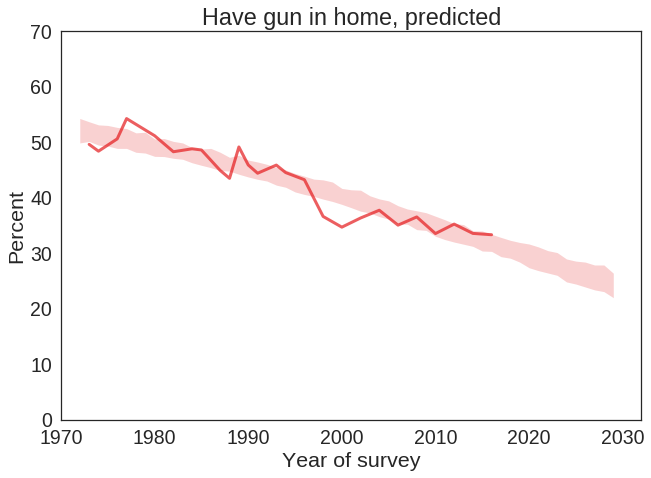

In [72]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', 'png')